In [5]:
# Probably more imports than are really necessary...
import os
import pickle

import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from tqdm import tqdm
import librosa
import numpy as np
import miditoolkit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, average_precision_score, accuracy_score
import random
import pretty_midi
import librosa
from torch.cuda.amp import autocast, GradScaler
import torch.optim as optim
from sklearn.metrics import average_precision_score


In [6]:
TAGS = ['rock', 'oldies', 'jazz', 'pop', 'dance', 'blues', 'punk', 'chill', 'electronic', 'country']
tag_to_index = {tag: i for i, tag in enumerate(TAGS)}


# do multi-hot encoding

def multi_hot_encode(tags):
    """
    Given a list of tag strings, return a multi-hot encoded tensor.
    Example input: ['jazz', 'pop']
    Output: tensor([0., 0., 1., 1., 0., 0., 0., 0., 0., 0.])
    """
    vec = torch.zeros(len(TAGS), dtype=torch.float32)
    for tag in tags:
        if tag in tag_to_index:
            vec[tag_to_index[tag]] = 1.0
        else:
            raise ValueError(f"Unknown tag: {tag}")
    return vec


In [7]:
dataroot3 = "data/student_files/task3_audio_classification/"

In [8]:
def save_model(model, filepath='sol_3.pt'):
    """Save a PyTorch model to a file"""
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

def load_model(model_class, filepath='sol_3.pt', *args, **kwargs):
    """Load a PyTorch model from a file"""
    model = model_class(*args, **kwargs)  # instantiate the model
    model.load_state_dict(torch.load(filepath))
    model.eval()  # optional: sets dropout/batchnorm to eval mode
    print(f"Model loaded from {filepath}")
    return model

In [9]:
from mido import MidiFile
from sklearn.model_selection import train_test_split
from itertools import islice
import fluidsynth

SAMPLE_RATE = 16000

# create train loader 

def extract_waveform(path):
    # Your code here
    wave, sr = librosa.load(path, sr=SAMPLE_RATE)
    return wave 

def extract_q(w):
    # Calculate frequency range that works with your sample rate
    fmin = 32.70  # C1 note in Hz
    fmax = 7000.0  # Just under Nyquist frequency
    
    # Use bins_per_octave to control the distribution
    bins_per_octave = int(128 / np.log2(fmax/fmin))
    
    result = librosa.cqt(
        y=w, 
        sr=SAMPLE_RATE, 
        n_bins=64,
        bins_per_octave=bins_per_octave,
        fmin=fmin,
        hop_length=313
    )
    
    result = librosa.amplitude_to_db(np.abs(result))
    return torch.FloatTensor(result)


def extract_mfcc(w):
    # Your code here:
    # load using librosa.feature.mfcc
    mfcc = librosa.feature.mfcc(y=w, sr=SAMPLE_RATE, n_mfcc = 128, hop_length=313)
    
    return torch.FloatTensor(mfcc)

def extract_spec(w, n_mels=128, max_time=512):
    mel_spec = librosa.feature.melspectrogram(
        y=w, 
        sr=SAMPLE_RATE,
        hop_length=313,
        n_mels=n_mels,
        fmin=0,
        fmax=SAMPLE_RATE / 2
    )

    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Pad or crop time dimension
    T = mel_spec_db.shape[1]
    if T < max_time:
        pad_width = max_time - T
        mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)))
    else:
        mel_spec_db = mel_spec_db[:, :max_time]
    
    return torch.FloatTensor(mel_spec_db)  # (n_mels, max_time)



def pad_or_truncate(spec, max_time=500):

    freq_bins, time_bins = spec.shape
    if time_bins > max_time:
        return spec[:, :max_time]
    elif time_bins < max_time:
        pad_width = max_time - time_bins
        return F.pad(spec, (0, pad_width), mode='constant', value=0)
    return spec

import torch
import pretty_midi
from sklearn.model_selection import train_test_split

def features(path):
    # get mfcc, spec, q transform for a file
    
    full_path = dataroot3 + '/' + path
    
    w = extract_waveform(full_path)
    
    # pad or truncate here 
    mfcc = pad_or_truncate(extract_mfcc(w), max_time=512)
    spec = pad_or_truncate(extract_spec(w), max_time=512)
    q = pad_or_truncate(extract_q(w), max_time=512)
    
    # q is at 64x512; and i need it to be at 128x512
    # if q.shape[0] < 128:
    q = q.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 84, 512)
    q = F.interpolate(q, size=(128, 512), mode='bilinear', align_corners=False)
    q = q.squeeze(0).squeeze(0)  # Back to shape: (128, 512)
    
    
    # mfcc = mfcc.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 84, 512)
    # mfcc = F.interpolate(mfcc, size=(128, 512), mode='bilinear', align_corners=False)
    # mfcc = mfcc.squeeze(0).squeeze(0)  # Back to shape: (128, 512)
        
    # print(f"Q shape: {q.shape}")  # <== DEBUG line
    # print(f"MFCC: {mfcc.shape}")  # <== DEBUG line
    # print(f"Spec shape: {spec.shape}")  # <== DEBUG line



    
    return mfcc, spec, q

In [10]:
features('train/0.wav')

python(6860) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6861) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


(tensor([[-3.3780e+02, -3.1909e+02, -3.2192e+02,  ..., -4.4202e+01,
          -4.9421e+01, -6.5830e+01],
         [ 8.3267e+01,  8.6681e+01,  8.5426e+01,  ...,  1.7716e+01,
           2.4289e+01,  3.4539e+01],
         [-2.6709e+01, -3.3490e+01, -3.4710e+01,  ...,  3.0015e+01,
           3.6966e+01,  4.1554e+01],
         ...,
         [ 3.1587e-02, -8.6079e-01, -1.4015e+00,  ..., -2.5887e-02,
          -3.2444e-01, -7.9310e-01],
         [-1.2375e+00, -2.1217e+00, -1.5122e+00,  ...,  3.5742e-01,
           2.0656e-01,  6.0570e-02],
         [-2.8523e-01, -1.0276e+00, -1.7786e+00,  ..., -2.9548e-02,
           5.4415e-01,  1.1081e+00]]),
 tensor([[-64.4517, -65.3846, -69.1503,  ..., -25.6241, -25.5115, -26.3162],
         [-55.3488, -54.6433, -53.8988,  ..., -13.5494, -15.2853, -18.6953],
         [-46.8266, -45.1533, -46.9443,  ...,  -9.4312, -11.2589, -12.0087],
         ...,
         [-80.0000, -80.0000, -80.0000,  ..., -42.1651, -41.5706, -43.8325],
         [-80.0000, -80.0000, -8

In [11]:

from joblib import Parallel, delayed

def create_datasets(size=None, val_split=0.2, n_jobs=4):
    # Load data
    with open(dataroot3 + "/train.json", 'r') as f:
        train_json = eval(f.read())
    
    # Limit size if specified
    if size is not None:
        train_json = dict(list(train_json.items())[:size])
    
    # Parallel feature extraction
    keys = list(train_json.keys())
    values = list(train_json.values())

    # Parallel feature extraction (mfcc, spec, q → stacked into shape [3, 128, 512])
    def process(key):
        mfcc, spec, q = features(key)
        x = torch.stack([mfcc, spec, q], dim=0)  # shape: (3, 128, 512)
        return x

    X = Parallel(n_jobs=n_jobs)(
        delayed(process)(key) for key in keys
    )
    y = torch.stack([multi_hot_encode(tags) for tags in values])
    
    
    # Convert to tensors
    X = torch.stack(X)  # shape: (N, 3, 128, 512)
    y = torch.tensor(y, dtype=torch.float32)  # shape: (N, num_classes) for multilabel

    
 
    return X, y

In [12]:
X_data, y_data = create_datasets()

python(6864) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6865) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6866) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6867) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6868) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6869) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/var/folders/wv/j6ybhf8906j4bmnp171wtn680000gn/T/ipykernel_6059/1743451323.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)  # shape: (N, num_classes) for multilabel


In [13]:
# Save data
import pickle

train_data_dict = {'x': X_data, 'y': y_data}

with open("task3_train_data.pkl", "wb") as file:
    pickle.dump(train_data_dict, file)

In [11]:
# load data
with open("task3_train_data.pkl", "rb") as file:
    data = pickle.load(file)

X_data = data['x']
y_data = data['y']

In [12]:
class CustomAudioDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, use_modalities=("mfcc", "spec")):
        """
        use_modalities: tuple of 2 modalities to use out of ("mfcc", "spec", "q")
        """
        self.X = X
        self.y = y
        self.use_modalities = use_modalities
        self.modality_to_idx = {"mfcc": 0, "spec": 1, "q": 2}

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx]  # shape: (3, 128, 512)
        label = self.y[idx]

        # Select only the two specified modalities
        selected = [x[self.modality_to_idx[modality]] for modality in self.use_modalities]
        
        selected[0] = selected[0].unsqueeze(0)
        selected[1] = selected[1].unsqueeze(0)


        return selected[0], selected[1], label

In [13]:
from skmultilearn.model_selection import iterative_train_test_split

# X_data: shape (n_samples, channels, height, width)
# Y_data: shape (n_samples, n_labels)

# Flatten X for splitting
X_flat = X_data.reshape((X_data.shape[0], -1))

# Split preserving multilabel distribution
X_train_flat, y_train, X_val_flat, y_val = iterative_train_test_split(
    X_flat.numpy(), y_data.numpy(), test_size=0.1
)

# Reshape X back to original shape
X_train = torch.tensor(X_train_flat).reshape(-1, *X_data.shape[1:])
X_val = torch.tensor(X_val_flat).reshape(-1, *X_data.shape[1:])
y_train = torch.tensor(y_train)
y_val = torch.tensor(y_val)

In [14]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)  

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

/var/folders/wv/j6ybhf8906j4bmnp171wtn680000gn/T/ipykernel_78449/1736831912.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
/var/folders/wv/j6ybhf8906j4bmnp171wtn680000gn/T/ipykernel_78449/1736831912.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)
/var/folders/wv/j6ybhf8906j4bmnp171wtn680000gn/T/ipykernel_78449/1736831912.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val, dtype=torch.float32)
/var/

In [15]:
train_dataset = CustomAudioDataset(X_train, y_train, use_modalities=("spec", "mfcc"))
val_dataset = CustomAudioDataset(X_val, y_val, use_modalities=("spec", "mfcc"))

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [1]:
import torch
from collections import Counter

def verify_data(train_loader, num_classes=10):
    """Check data for potential issues and class frequency distribution for multi-label data.
       Also returns pos_weight tensor for BCEWithLogitsLoss to handle class imbalance.
    """
    batch_count = 0
    label_counter = Counter()
    total_assignments = 0  # Total number of 1s in all label vectors
    sample_count = 0
    
    for spec, mfcc, labels in train_loader:
        batch_count += 1
        label_indices = labels.int()
        
        for label_vector in label_indices:
            total_assignments += label_vector.sum().item()
        
        sample_count += labels.size(0)
        
        for i in range(num_classes):
            label_counter[i] += (label_indices[:, i] == 1).sum().item()
        
        # Check for NaN/Inf
        if torch.isnan(spec).any() or torch.isinf(spec).any():
            print("WARNING: NaN or Inf values found in spectrogram data!")
        
        if torch.isnan(mfcc).any() or torch.isinf(mfcc).any():
            print("WARNING: NaN or Inf values found in MFCC data!")
        
        print(f"Batch {batch_count}:")
        print(f"  Spec range: [{spec.min().item():.4f}, {spec.max().item():.4f}]")
        print(f"  MFCC range: [{mfcc.min().item():.4f}, {mfcc.max().item():.4f}]")
    
    print(f"\nTotal samples processed: {sample_count}")
    print(f"Total class assignments (1s): {total_assignments}")
    
    print("\nClass frequency distribution:")
    counts = []
    for i in range(num_classes):
        count = label_counter[i]
        counts.append(count)
        print(f"  Class {i}: {count} assignments ({count / total_assignments:.2%})")
    
    # Compute pos_weight = (N - count) / count for each class
    label_counts_tensor = torch.tensor(counts, dtype=torch.float)
    pos_weight = (sample_count - label_counts_tensor) / label_counts_tensor
    
    
    print("\nComputed pos_weight (for BCEWithLogitsLoss):")
    for i, w in enumerate(pos_weight):
        print(f"  Class {i}: {w.item():.4f}")

    return pos_weight

In [46]:
pos_weight = verify_data(train_loader)
pos_weight = torch.log1p(pos_weight) 
pos_weight

Batch 1:
  Spec range: [-100.0000, 38.4801]
  MFCC range: [-720.3176, 279.7045]
Batch 2:
  Spec range: [-100.0000, 41.0473]
  MFCC range: [-761.3607, 259.0165]
Batch 3:
  Spec range: [-100.0000, 40.9389]
  MFCC range: [-750.5443, 291.9468]
Batch 4:
  Spec range: [-100.0000, 40.8011]
  MFCC range: [-761.3607, 275.6665]
Batch 5:
  Spec range: [-100.0000, 39.8696]
  MFCC range: [-749.2927, 279.1788]
Batch 6:
  Spec range: [-100.0000, 40.2640]
  MFCC range: [-813.8968, 279.7045]
Batch 7:
  Spec range: [-100.0000, 38.7742]
  MFCC range: [-778.2305, 264.6042]
Batch 8:
  Spec range: [-100.0000, 39.3283]
  MFCC range: [-751.4969, 251.0771]
Batch 9:
  Spec range: [-100.0000, 39.4752]
  MFCC range: [-756.3655, 267.7703]
Batch 10:
  Spec range: [-100.0000, 38.9064]
  MFCC range: [-753.0217, 260.6252]
Batch 11:
  Spec range: [-100.0000, 41.2199]
  MFCC range: [-727.1412, 255.5780]
Batch 12:
  Spec range: [-100.0000, 39.5128]
  MFCC range: [-752.8512, 279.5922]
Batch 13:
  Spec range: [-92.4183, 39

tensor([0.7131, 3.1985, 2.3282, 1.7641, 3.1651, 2.7953, 3.1014, 4.4754, 2.0235,
        2.7294])

Model Architecture

In [18]:
import torch
import torch.nn as nn
import torchvision.models as models
import ast

class ThresholdLayer(nn.Module):
    def __init__(self, num_classes):
        super(ThresholdLayer, self).__init__()
        self.thresholds = nn.Parameter(torch.zeros(num_classes))  # Trainable thresholds

    def forward(self, logits):
        # Apply the threshold per class
        probs = torch.sigmoid(logits)
        return (probs > self.thresholds).float()  # Binarize based on thresholds

class TransformerBlock(nn.Module):
    def __init__(self, dim, heads=4, ff_dim=256, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=heads, batch_first=True)
        self.norm1 = nn.LayerNorm(dim)
        self.ff = nn.Sequential(
            nn.Linear(dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, dim)
        )
        self.norm2 = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attn_out, _ = self.attn(x, x, x)
        x = self.norm1(x + self.dropout(attn_out))
        ff_out = self.ff(x)
        x = self.norm2(x + self.dropout(ff_out))
        return x
    
class DualResNetWithTransformer(nn.Module):
    def __init__(self, num_labels, transformer_dim=512, seq_len=4):
        super().__init__()
        
        # Backbone ResNet-18 - Use weights=None instead of pretrained=True
        def resnet_branch():
            model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
            
            # Replace the first layer to handle 1-channel input
            model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
            
            # Reset the weights of the first conv layer since we modified it
            nn.init.kaiming_normal_(model.conv1.weight, mode='fan_out', nonlinearity='relu')
            
            return nn.Sequential(*list(model.children())[:-2])  # remove avgpool and fc

        self.spec_branch = resnet_branch()
        self.mfcc_branch = resnet_branch()
        
        # Disable gradients for pretrained layers to make training faster initially
        for param in list(self.spec_branch.parameters())[:-9]:  # Keep last few layers trainable
            param.requires_grad = False
        for param in list(self.mfcc_branch.parameters())[:-9]:
            param.requires_grad = False
        
        # Instead of pooling completely:
        self.partial_pool = nn.AdaptiveAvgPool2d((seq_len, 1))  # Output: (B, 512, seq_len, 1)
        
        # Multiple transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(dim=transformer_dim) for _ in range(3)
        ])

        self.attn_fusion = AttentionFusion(embed_dim=512)

        # Modified classifier without sigmoid (will be handled by loss function)
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),  # Increased dropout for better regularization
            nn.Linear(256, num_labels)
        )
        
        # # Threshold Layer for per-class thresholding
        # self.threshold_layer = ThresholdLayer(num_labels)


    def forward(self, spec, mfcc):
        # ResNet feature maps (B, 512, H, W)
        x_spec = self.spec_branch(spec)  # (B, 512, H, W)
        x_mfcc = self.mfcc_branch(mfcc)  # (B, 512, H, W)
        
        # Partial pooling to create sequence
        x_spec = self.partial_pool(x_spec).squeeze(-1).permute(0, 2, 1)  # (B, seq_len, 512)
        x_mfcc = self.partial_pool(x_mfcc).squeeze(-1).permute(0, 2, 1)  # (B, seq_len, 512)
        
        # Fuse corresponding sequence elements
        x_fused = torch.zeros_like(x_spec)
        for i in range(x_spec.size(1)):
            x_fused[:, i] = self.attn_fusion(x_spec[:, i], x_mfcc[:, i])
        
        # Pass through transformer blocks
        x = x_fused
        for block in self.transformer_blocks:
            x = block(x)
            
        # Global pooling across sequence dimension
        x_out = torch.mean(x, dim=1)  # (B, 512)
        
        # Return logits (without sigmoid) - BCEWithLogitsLoss will handle it
        logits = self.classifier(x_out)
        
        # Apply the learned per-class thresholds to the logits
        # thresholded_preds = self.threshold_layer(logits)
        
        return logits

# Enhanced AttentionFusion with layer normalization
class AttentionFusion(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.fusion = nn.Sequential(
            nn.Linear(embed_dim * 2, embed_dim),
            nn.LayerNorm(embed_dim),
            nn.ReLU(),
        )
        self.attn = nn.Sequential(
            nn.Linear(embed_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x1, x2):
        x = torch.cat([x1, x2], dim=1)  # (B, 2*D)
        fused = self.fusion(x)          # (B, D)
        alpha = self.attn(fused)        # (B, 1)
        return alpha * x1 + (1 - alpha) * x2  # Weighted fusion


In [77]:
import torch
import torch.nn as nn
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from joblib import Parallel, delayed
from functools import partial
import tqdm
import os

class Model:
    def __init__(self, num_labels):
        self.model = DualResNetWithTransformer(num_labels=num_labels)
        self.train_acc = []
        self.val_acc = []
        self.train_map=[]
        self.train_losses=[]
        self.val_losses=[]
        self.val_map=[]

    def train(self, train_loader, val_loader, epochs=100, save_path="sol3_dualResNetTransformer.pt"):
        torch.mps.empty_cache()
        device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
        print(f"Using device: {device}")
        
        model = self.model.to(device)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
        
        # Create separate param groups
        def get_trainable_params():
            return [
                {'params': [p for p in model.spec_branch.parameters() if p.requires_grad], 'lr': 0.0001},
                {'params': [p for p in model.mfcc_branch.parameters() if p.requires_grad], 'lr': 0.0001},
                {'params': model.attn_fusion.parameters(), 'lr': 0.001},
                {'params': [p for block in model.transformer_blocks for p in block.parameters()], 'lr': 0.0005},
                {'params': model.classifier.parameters(), 'lr': 0.001},
            ]
    
        optimizer = optim.Adam(get_trainable_params())
        
        best_val_map_score = float('-inf')  # Start with the lowest possible value for mAP
        patience_counter = 0
        patience = 10
    
        for epoch in range(epochs):
            model.train()
            train_loss = 0.0
            correct_train = 0
            total_train = 0
            
            from tqdm import tqdm
            loader_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
    
            all_train_probs = []
            all_train_labels = []
    
            for spec, mfcc, labels in loader_iter:
                spec, mfcc, labels = spec.to(device), mfcc.to(device), labels.to(device).float()
    
                optimizer.zero_grad()
                
                # Forward pass without autocast
                logits = model(spec, mfcc)  # Now model returns both logits and thresholds
                loss = criterion(logits, labels)
    
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                
                train_loss += loss.item()
                
                probs = torch.sigmoid(logits).detach().cpu()
                preds = (probs > 0.5).float()

                labels_cpu = labels.detach().cpu()
                
                correct_train += (preds == labels_cpu).sum().item()
                total_train += labels_cpu.numel()
                
                # Store for mAP calculation
                all_train_probs.append(preds)
                all_train_labels.append(labels_cpu)

            train_probs = torch.cat(all_train_probs)
            train_labels = torch.cat(all_train_labels)
            
            train_map_score = average_precision_score(train_labels.numpy(), train_probs.numpy(), average="macro")
            self.train_map.append(train_map_score)

            avg_train_loss = train_loss / len(train_loader)
            train_accuracy = correct_train / total_train
            self.train_losses.append(avg_train_loss)
            self.train_acc.append(train_accuracy)
    
            # === Validation ===
            model.eval()
            val_loss = 0.0
            correct_val = 0
            total_val = 0
    
            all_val_probs = []
            all_val_labels = []
    
            with torch.no_grad():
                for spec, mfcc, labels in val_loader:
                    spec, mfcc, labels = spec.to(device), mfcc.to(device), labels.to(device).float()
                    logits = model(spec, mfcc)
                    
                    
                    loss = criterion(logits, labels)
                    val_loss += loss.item()
                    probs = torch.sigmoid(logits).detach().cpu()
                    preds = (probs > 0.5).float()
                    labels_cpu = labels.detach().cpu()
                    
                    correct_val += (preds == labels_cpu).sum().item()
                    total_val += labels_cpu.numel()
                    
                    # Store for mAP
                    all_val_probs.append(preds)
                    all_val_labels.append(labels_cpu)

            val_probs = torch.cat(all_val_probs)
            val_labels = torch.cat(all_val_labels)
            
            val_map_score = average_precision_score(val_labels.numpy(), val_probs.numpy(), average="macro")
            self.val_map.append(val_map_score)

            avg_val_loss = val_loss / len(val_loader)
            val_accuracy = correct_val / total_val
            self.val_losses.append(avg_val_loss)
            self.val_acc.append(val_accuracy)
    
            print(f"Epoch {epoch+1}/{epochs} — Train Loss: {avg_train_loss:.4f}, Acc: {train_accuracy:.4f}, mAP: {train_map_score:.4f} | Val Loss: {avg_val_loss:.4f}, Acc: {val_accuracy:.4f}, mAP: {val_map_score:.4f}")

    
            # Save best model based on val mAP
            if val_map_score > best_val_map_score:
                best_val_map_score = val_map_score
                patience_counter = 0
                torch.save(model.state_dict(), save_path)
                print(f"Saving model (improved val mAP: {best_val_map_score:.4f})")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping triggered.")
                    break
    
            # === Unfreeze partial backbone after epoch 10 ===
            if epoch == 10:
                print("Unfreezing the last residual blocks of ResNet branches...")
                def unfreeze_last_block(branch):
                    for name, module in branch.named_children():
                        if 'layer4' in name:
                            for param in module.parameters():
                                param.requires_grad = True
    
                unfreeze_last_block(model.spec_branch)
                unfreeze_last_block(model.mfcc_branch)
    
                optimizer = optim.Adam(get_trainable_params())  # Update optimizer with new params
    
        self.model.load_state_dict(torch.load(save_path))
        self.plot_training_metrics()

    def plot_training_metrics(self):
        """Plot training and validation metrics"""
        import matplotlib.pyplot as plt
        
        plt.figure(figsize=(12, 12))
        
        # Plot losses
        plt.subplot(3, 1, 1)
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.title('Loss vs. Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        
        # Plot accuracies
        plt.subplot(3, 1, 2)
        plt.plot(self.train_acc, label='Training Accuracy')
        plt.plot(self.val_acc, label='Validation Accuracy')
        plt.title('Accuracy vs. Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        
        
        # Plot mAP
        plt.subplot(3,1,3)
        plt.plot(self.train_map, label='Training mAP')
        plt.plot(self.val_map, label='Validation mAP')
        plt.title('mAP vs. Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Mean Average Precision')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.savefig('training_metrics.png')
        print("Training metrics plot saved as 'training_metrics.png'")


In [ ]:
EPOCHS = 30
model = Model(10)
model.train(train_loader, val_loader, EPOCHS)

Using device: mps


Epoch 1/30 [Train]: 100%|██████████| 29/29 [01:53<00:00,  3.91s/it]


Epoch 1/30 — Train Loss: 0.4577, Acc: 0.8784, mAP: 0.1535 | Val Loss: 0.4196, Acc: 0.9140, mAP: 0.2141
Saving model (improved val mAP: 0.2141)


Epoch 2/30 [Train]: 100%|██████████| 29/29 [01:31<00:00,  3.15s/it]


Epoch 2/30 — Train Loss: 0.3623, Acc: 0.9054, mAP: 0.2346 | Val Loss: 0.3885, Acc: 0.9233, mAP: 0.2720
Saving model (improved val mAP: 0.2720)


Epoch 3/30 [Train]: 100%|██████████| 29/29 [01:28<00:00,  3.06s/it]


Epoch 3/30 — Train Loss: 0.2921, Acc: 0.9209, mAP: 0.3416 | Val Loss: 0.3796, Acc: 0.8960, mAP: 0.3014
Saving model (improved val mAP: 0.3014)


Epoch 4/30 [Train]: 100%|██████████| 29/29 [01:27<00:00,  3.00s/it]


Epoch 4/30 — Train Loss: 0.2172, Acc: 0.9387, mAP: 0.4836 | Val Loss: 0.4386, Acc: 0.9115, mAP: 0.2844


Epoch 5/30 [Train]: 100%|██████████| 29/29 [01:40<00:00,  3.45s/it]


Epoch 5/30 — Train Loss: 0.1505, Acc: 0.9588, mAP: 0.6176 | Val Loss: 0.4941, Acc: 0.9150, mAP: 0.3661
Saving model (improved val mAP: 0.3661)


Epoch 6/30 [Train]: 100%|██████████| 29/29 [01:46<00:00,  3.67s/it]


Epoch 6/30 — Train Loss: 0.1047, Acc: 0.9718, mAP: 0.7472 | Val Loss: 0.5895, Acc: 0.9296, mAP: 0.3831
Saving model (improved val mAP: 0.3831)


Epoch 7/30 [Train]: 100%|██████████| 29/29 [01:32<00:00,  3.21s/it]


Epoch 7/30 — Train Loss: 0.0655, Acc: 0.9828, mAP: 0.8621 | Val Loss: 0.6740, Acc: 0.9123, mAP: 0.3277


Epoch 8/30 [Train]: 100%|██████████| 29/29 [01:53<00:00,  3.90s/it]


Epoch 8/30 — Train Loss: 0.0568, Acc: 0.9851, mAP: 0.8838 | Val Loss: 0.6365, Acc: 0.9221, mAP: 0.3974
Saving model (improved val mAP: 0.3974)


Epoch 9/30 [Train]: 100%|██████████| 29/29 [00:46<00:00,  1.59s/it]


Epoch 9/30 — Train Loss: 0.0466, Acc: 0.9871, mAP: 0.8784 | Val Loss: 0.7009, Acc: 0.9273, mAP: 0.3847


Epoch 10/30 [Train]: 100%|██████████| 29/29 [00:35<00:00,  1.21s/it]


Epoch 10/30 — Train Loss: 0.0488, Acc: 0.9873, mAP: 0.8796 | Val Loss: 0.8215, Acc: 0.9321, mAP: 0.3986
Saving model (improved val mAP: 0.3986)


Epoch 11/30 [Train]: 100%|██████████| 29/29 [04:15<00:00,  8.80s/it]


Epoch 11/30 — Train Loss: 0.0412, Acc: 0.9893, mAP: 0.9176 | Val Loss: 0.7012, Acc: 0.9263, mAP: 0.3945
Unfreezing the last residual blocks of ResNet branches...


Epoch 12/30 [Train]: 100%|██████████| 29/29 [04:13<00:00,  8.74s/it]


Epoch 12/30 — Train Loss: 0.0415, Acc: 0.9890, mAP: 0.9067 | Val Loss: 0.8877, Acc: 0.9213, mAP: 0.3686


Epoch 13/30 [Train]: 100%|██████████| 29/29 [01:49<00:00,  3.77s/it]


Epoch 13/30 — Train Loss: 0.0421, Acc: 0.9888, mAP: 0.8929 | Val Loss: 0.8557, Acc: 0.9363, mAP: 0.4046
Saving model (improved val mAP: 0.4046)


Epoch 14/30 [Train]: 100%|██████████| 29/29 [01:48<00:00,  3.74s/it]


Epoch 14/30 — Train Loss: 0.0338, Acc: 0.9911, mAP: 0.9108 | Val Loss: 0.9399, Acc: 0.9296, mAP: 0.3692


Epoch 15/30 [Train]: 100%|██████████| 29/29 [01:58<00:00,  4.07s/it]


Epoch 15/30 — Train Loss: 0.0308, Acc: 0.9920, mAP: 0.9155 | Val Loss: 0.9688, Acc: 0.9206, mAP: 0.3516


Epoch 16/30 [Train]: 100%|██████████| 29/29 [01:15<00:00,  2.60s/it]


Epoch 16/30 — Train Loss: 0.0311, Acc: 0.9920, mAP: 0.9231 | Val Loss: 0.8583, Acc: 0.9155, mAP: 0.3862


Epoch 17/30 [Train]: 100%|██████████| 29/29 [01:25<00:00,  2.94s/it]


Epoch 17/30 — Train Loss: 0.0361, Acc: 0.9918, mAP: 0.9226 | Val Loss: 0.9473, Acc: 0.9273, mAP: 0.3847


Epoch 18/30 [Train]: 100%|██████████| 29/29 [10:47<00:00, 22.32s/it] 


Epoch 18/30 — Train Loss: 0.0245, Acc: 0.9934, mAP: 0.9374 | Val Loss: 1.0164, Acc: 0.9273, mAP: 0.3482


Epoch 19/30 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

In [64]:
import numpy as np
from sklearn.metrics import f1_score
import torch

def find_best_thresholds(logits, labels, metric='f1'):
    """
    Finds the best threshold for each class to maximize the selected metric (F1 or AP).

    Args:
        logits (torch.Tensor): shape (num_samples, num_classes)
        labels (torch.Tensor): shape (num_samples, num_classes)
        metric (str): either 'f1' or 'ap'

    Returns:
        torch.Tensor: optimal threshold for each class, shape (num_classes,)
    """
    num_classes = logits.shape[1]
    thresholds = torch.zeros(num_classes)

    probs = torch.sigmoid(logits).cpu().numpy()
    labels = labels.cpu().numpy()

    for c in range(num_classes):
        best_score = -1
        best_thresh = 0.5
        for thresh in np.linspace(0.0, 1.0, 101):
            preds = (probs[:, c] > thresh).astype(int)

            if metric == 'f1':
                score = f1_score(labels[:, c], preds, zero_division=0)
            elif metric == 'ap':
                from sklearn.metrics import average_precision_score
                # Not binarized, so we must compute AP with probs
                score = average_precision_score(labels[:, c], probs[:, c])
                break  # mAP doesn't use thresholds, use probs directly
            else:
                raise ValueError("Unsupported metric")

            if score > best_score:
                best_score = score
                best_thresh = thresh

        thresholds[c] = best_thresh

    return thresholds


In [76]:
all_logits = []
all_labels = []

with torch.no_grad():
    for spec,mfcc,labels in val_loader:
        print(spec.shape)
        print(mfcc.shape)
        logits = model.model(spec,mfcc)
        all_logits.append(logits)
        all_labels.append(labels)

all_logits = torch.cat(all_logits)
all_labels = torch.cat(all_labels)

# Find best thresholds using F1
best_thresholds = find_best_thresholds(all_logits, all_labels, metric='ap')

# Set the thresholds in your ThresholdLayer
model.model.threshold_layer.thresholds.data = best_thresholds


torch.Size([64, 1, 128, 512])
torch.Size([64, 1, 128, 512])


RuntimeError: Mismatched Tensor types in NNPack convolutionOutput

In [ ]:
def debug_single_batch(model, train_loader, device):
    """Test model on a single batch repeatedly to verify overfitting capability"""
    model.train()
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Get a single batch
    for spec, mfcc, labels in train_loader:
        break
    
    spec = spec.to(device)
    mfcc = mfcc.to(device)
    labels = labels.to(device).float()
    
    print("Starting single batch overfitting test...")
    
    # Train on this single batch for many iterations
    for i in range(100):
        optimizer.zero_grad()
        logits = model(spec, mfcc)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        with torch.no_grad():
            outputs = torch.sigmoid(logits)
            preds = (outputs > 0.5).float()
            accuracy = (preds == labels).float().mean().item()
        
        if i % 10 == 0:
            print(f"Iteration {i}: Loss = {loss.item():.4f}, Accuracy = {accuracy:.4f}")
    
    print("Single batch test complete.")

In [ ]:
# debug_single_batch(model, train_loader, torch.device("mps"))

In [ ]:
# from sklearn.metrics import precision_recall_curve
# 
# # After training:
# all_probs = torch.cat(all_val_probs).numpy()
# all_labels = torch.cat(all_val_labels).numpy()
# 
# best_thresholds = []
# for i in range(num_labels):
#     precision, recall, thresholds = precision_recall_curve(all_labels[:, i], all_probs[:, i])
#     f1 = 2 * precision * recall / (precision + recall + 1e-6)
#     best_idx = f1.argmax()
#     best_thresholds.append(thresholds[best_idx])
# 
# # Save thresholds for inference
# model.threshold_layer.thresholds.data = torch.tensor(best_thresholds).to(device)


In [ ]:
def predict_instance(model, file1):
    device = torch.device("cpu")
    model = model.to(device)
    model.eval()

    spec, mfcc, _ = features(file1)
    spec = torch.tensor(spec, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    mfcc = torch.tensor(mfcc, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(spec, mfcc)  # logits: [1, num_labels], thresholds: [num_labels]
        print("logits:",logits)
        probs = torch.sigmoid(logits).squeeze(0)  # [num_labels]
        print("probs:",probs)
        preds = (probs > 0.5).int().cpu().tolist()

    return preds

In [ ]:
predict_instance(model.model, "test/197.wav")

In [51]:
# load test data
print("Loading and processing test data...")
with open(dataroot3+"/test.json"+'', 'r') as f:
    data = ast.literal_eval(f.read())

process_func = partial(features)
processed_test_data = Parallel(n_jobs=4)(
    delayed(process_func)(d) for d in tqdm.tqdm(data)
)
processed_test_data = [r for r in processed_test_data if r is not None]

Loading and processing test data...


  0%|          | 0/1000 [00:00<?, ?it/s]python(81040) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(81041) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(81042) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(81043) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 1000/1000 [00:07<00:00, 125.78it/s]


In [ ]:
import ast
import torch
import tqdm
from joblib import Parallel, delayed
from functools import partial

def predict(model, path, outpath=None, n_jobs=4, processed_data=None):
    device = torch.device("cpu")
    model = model.to(device)
    model.eval()

    # Load and process test data
    if not processed_data:
        print("Loading and processing test data...")
        with open(path, 'r') as f:
            data = ast.literal_eval(f.read())

        process_func = partial(features)
        results = Parallel(n_jobs=n_jobs)(
            delayed(process_func)(d) for d in tqdm.tqdm(data)
        )
        results = [r for r in results if r is not None]
    else:
        results = processed_data
        with open(path, 'r') as f:
            data = ast.literal_eval(f.read())

    specs = torch.stack([r[0] for r in results]).unsqueeze(1).to(device)
    mfccs = torch.stack([r[1] for r in results]).unsqueeze(1).to(device)

    # Predict
    with torch.no_grad():
        logits = model(specs, mfccs)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).int().cpu().tolist()

    predicted = [[TAGS[i] for i, val in enumerate(pred_vec) if val == 1] for pred_vec in preds]

    if len(predicted) == 1 and not isinstance(predicted[0], list):
        predicted = [predicted]

    predictions = dict(zip(data, predicted))

    if outpath:
        with open(outpath, "w") as z:
            z.write(str(predictions) + '\n')
        print(f"Predictions written to {outpath}")

    return predictions

In [ ]:
predict(model.model, dataroot3+"/test.json","predictions3.json", processed_data=processed_test_data)

In [41]:
from matplotlib import pyplot as plt
import seaborn as sns

def plot_cooccurrence_matrix(train_loader, num_classes=10):
    co_matrix = np.zeros((num_classes, num_classes))

    for _, _, labels in train_loader:
        labels = labels.int()
        batch_size = labels.size(0)

        for i in range(batch_size):
            active = labels[i].nonzero().squeeze().tolist()
            if isinstance(active, int):
                active = [active]
            for i in active:
                for j in active:
                    co_matrix[i][j] += 1

    plt.figure(figsize=(10, 8))
    sns.heatmap(co_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Label Co-occurrence Matrix")
    plt.xlabel("Class")
    plt.ylabel("Class")
    plt.show()

ValueError: Unknown format code 'd' for object of type 'float'

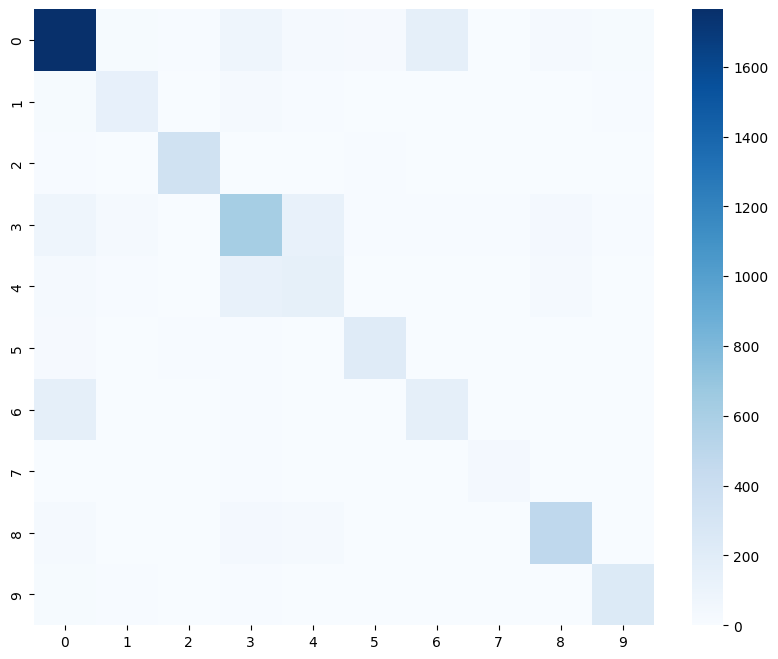

In [42]:
plot_cooccurrence_matrix(train_loader,10)